In [18]:
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd

In [19]:
df = pd.read_csv('labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [20]:
n = len(df)
breed = set(df['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

In [21]:
width = 299
X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
    X[i] = cv2.resize(cv2.imread('train/%s.jpg' % df['id'][i]), (width, width))
    y[i][class_to_num[df['breed'][i]]] = 1

100%|██████████| 10222/10222 [03:05<00:00, 55.13it/s]


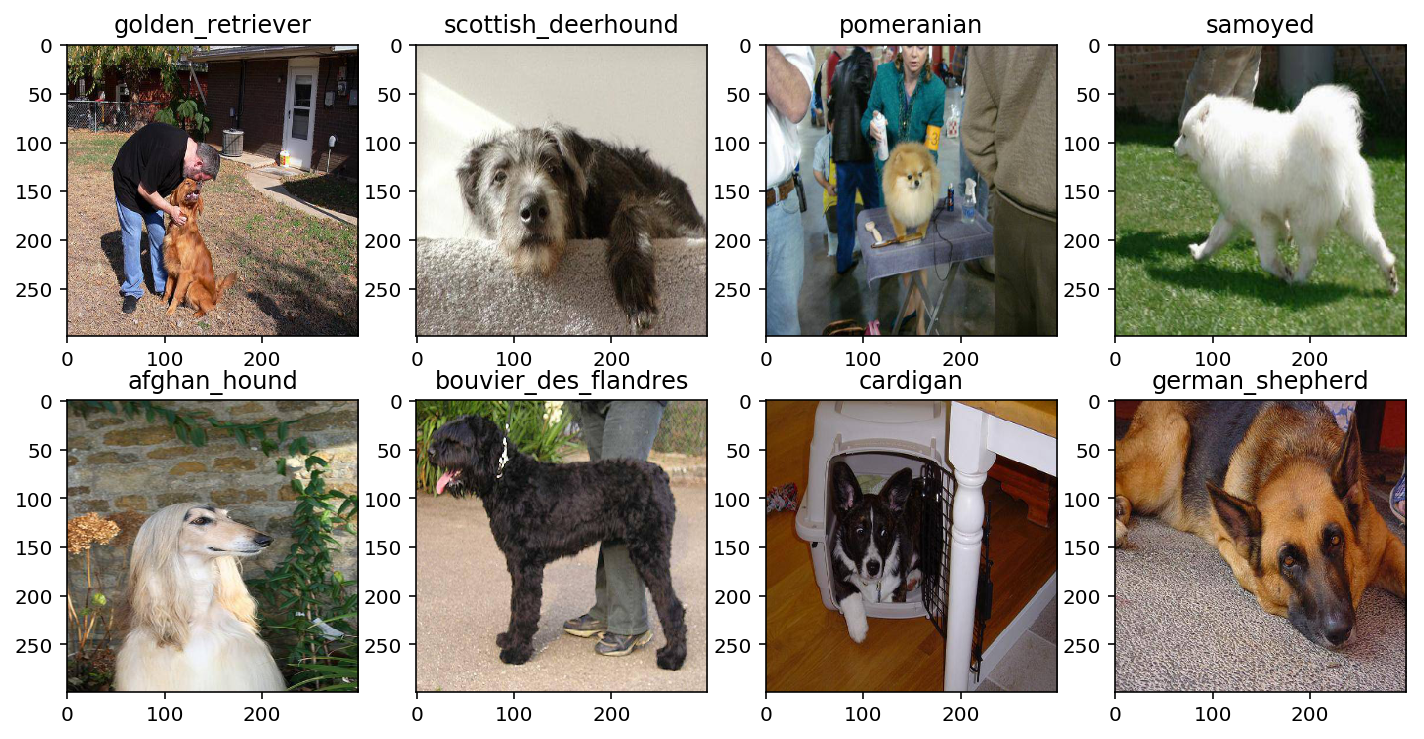

In [22]:
import random
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 6))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(num_to_class[y[random_index].argmax()])

In [23]:
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

In [24]:
def get_features(MODEL, data=X):
    cnn_model = MODEL(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    return features

In [26]:
inception_features = get_features(InceptionV3, X)
xception_features = get_features(Xception, X)
features = np.concatenate([inception_features, xception_features], axis=-1)

10222/10222 [==============================] - 256s   


In [27]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax')(x)
model = Model(inputs, x)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
h = model.fit(features, y, batch_size=128, epochs=10, validation_split=0.1)

Train on 9199 samples, validate on 1023 samples
Epoch 1/10
9199/9199 [==============================] - 2s - loss: 1.9117 - acc: 0.5957 - val_loss: 0.6983 - val_acc: 0.8065
Epoch 2/10
9199/9199 [==============================] - 0s - loss: 0.5827 - acc: 0.8373 - val_loss: 0.5827 - val_acc: 0.8201
Epoch 3/10
9199/9199 [==============================] - 0s - loss: 0.4398 - acc: 0.8740 - val_loss: 0.5028 - val_acc: 0.8416
Epoch 4/10
9199/9199 [==============================] - 0s - loss: 0.3652 - acc: 0.8926 - val_loss: 0.4877 - val_acc: 0.8543
Epoch 5/10
9199/9199 [==============================] - 0s - loss: 0.3045 - acc: 0.9130 - val_loss: 0.4780 - val_acc: 0.8485
Epoch 6/10
9199/9199 [==============================] - 0s - loss: 0.2648 - acc: 0.9243 - val_loss: 0.4657 - val_acc: 0.8602
Epoch 7/10
9199/9199 [==============================] - 0s - loss: 0.2289 - acc: 0.9375 - val_loss: 0.4670 - val_acc: 0.8514
Epoch 8/10
9199/9199 [==============================] - 0s - loss: 0.2014 - a

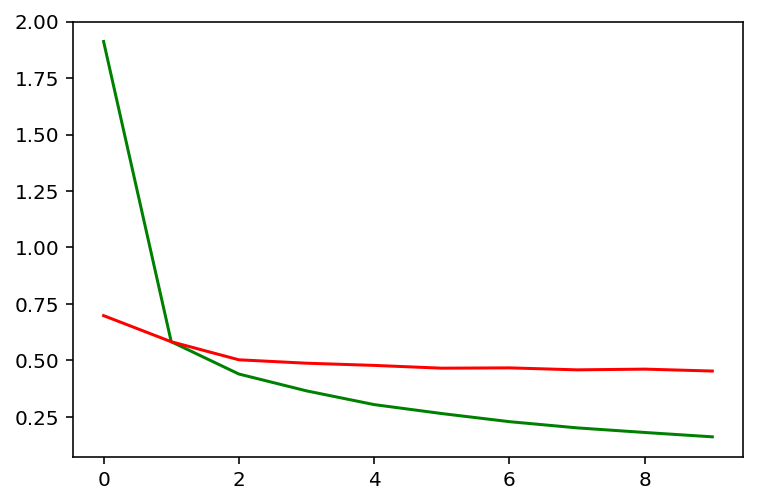

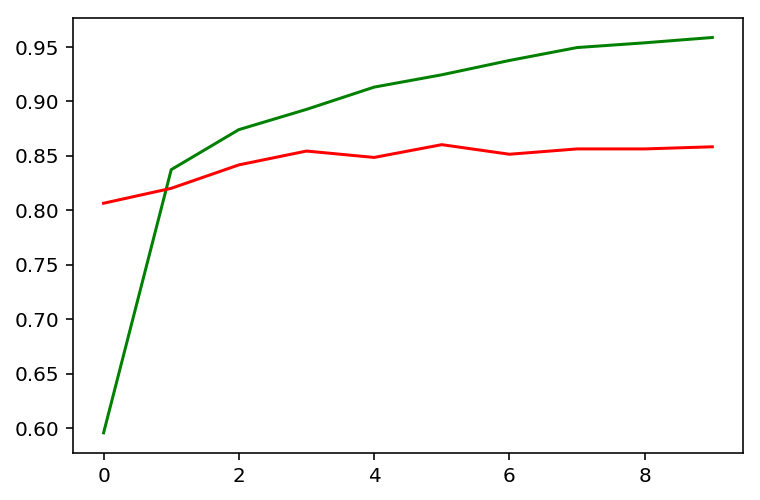

In [29]:
data = h.history

plt.figure(0)
plt.plot(data['loss'], 'g')
plt.plot(data['val_loss'], 'r')

plt.figure(1)
plt.plot(data['acc'], 'g')
plt.plot(data['val_acc'], 'r')

plt.show()

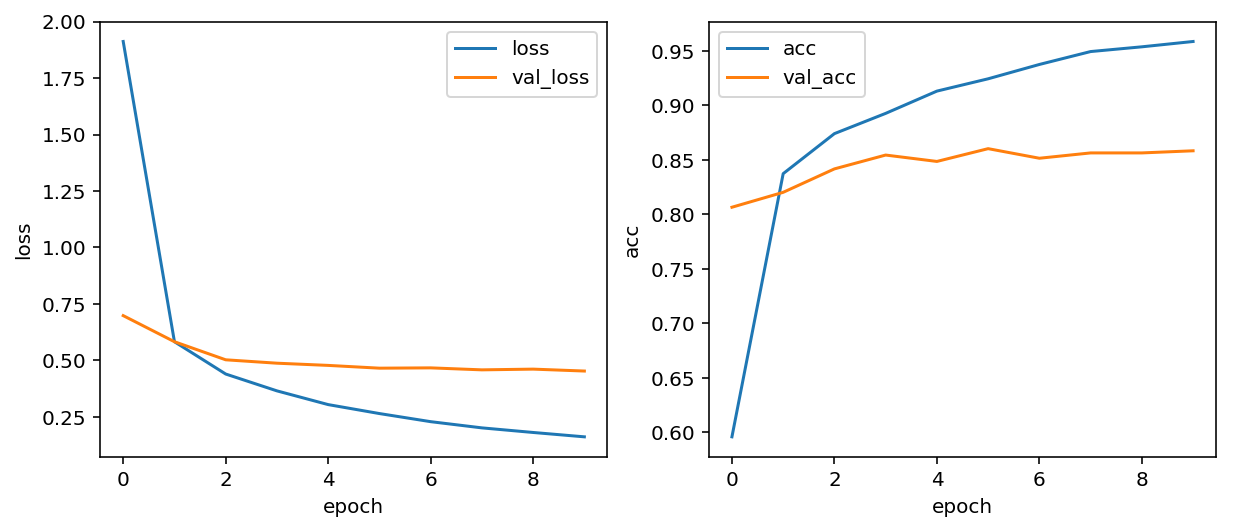

In [30]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')